In [87]:
import numpy as np
import pandas as pd
import os
import random
import time
import transformers
from keras.preprocessing.text import Tokenizer
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
from keras.preprocessing.sequence import pad_sequences
import tensorflow_hub as hub
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from torch import cuda,nn
import torch.autograd as autograd
import torch.nn.functional as F

In [2]:
torch.set_printoptions(precision=10)
!pip install transformers
# SEEDS 
# [3,42,107,33,17]
seed = 3
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
torch.manual_seed(seed)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dataset = 'clinc'

# Data

In [3]:
path_data = '\\Users\\Camilo\\Desktop\\tesis\\codes\\data\\'
df = pd.read_csv(path_data+dataset+'Data.csv', delimiter='@')
df = df.sample(frac=1)
df.text = df.text.apply(lambda x: str(x))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22500 entries, 17933 to 5994
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  22500 non-null  object
 1   label     22500 non-null  object
 2   group     22500 non-null  object
 3   text      22500 non-null  object
 4   class     22500 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [199]:
data = df['text'].apply(lambda x: len(str(x).split()))
print('Larges of percentiles')
np.percentile(data, [25, 50, 75,90,100])

Larges of percentiles


array([ 3.,  4.,  5.,  6., 15.])

# Embeddings

## GloVe

In [110]:
def loadGlove(df,dim=50):
    docs = df.text.values
    t = Tokenizer()
    t.fit_on_texts(docs)
    vocab_size = len(t.word_index) + 1
    # load the whole embedding into memory
    embeddings_index = dict()
    f = open('\\Users\\Camilo\\Desktop\\tesis\\codes\\embs\\glove.twitter.27B.'+str(dim)+'d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    embedding_matrix = np.zeros((vocab_size, dim))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    emb_m = torch.tensor(embedding_matrix)
    embeds = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=50,_weight=emb_m)

    return embeds,t,embeddings_index

def emb_Glove(df,max_length,t,emb):
    docs = df.text.values
    outs = df['class'].values
    encoded_docs = t.texts_to_sequences(docs)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    lookup_tensor = torch.tensor(padded_docs, dtype=torch.long)
    data_embed = emb(lookup_tensor)
    y = torch.tensor(outs, dtype=torch.int16)
    return  data_embed.to(torch.float32),y

In [69]:
emb,tok,voc = loadGlove(df[df.group == 'train'],dim=50)

Loaded 1193515 word vectors.


In [111]:
X_train,y_train = emb_Glove(df[df.group == 'train'],20,tok,emb)
X_val,y_val = emb_Glove(df[df.group == 'val'],20,tok,emb)
X_test,y_test = emb_Glove(df[df.group == 'test'],20,tok,emb)

In [139]:
def embGlove(df,max_length):
    docs = df.text.values
    outs = df['class'].values
    t = Tokenizer()
    t.fit_on_texts(docs)
    vocab_size = len(t.word_index) + 1
    encoded_docs = t.texts_to_sequences(docs)
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

    # load the whole embedding into memory
    embeddings_index = dict()
    f = open('\\Users\\Camilo\\Desktop\\tesis\\codes\\embs\\glove.twitter.27B.50d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index))

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((vocab_size, 50))
    for word, i in t.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    emb_m = torch.tensor(embedding_matrix)
    # loaded emb matrix
    embeds = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=50,_weight=emb_m)
    # embedding docs
    lookup_tensor = torch.tensor(padded_docs, dtype=torch.long)
  
    data_embed = embeds(lookup_tensor)
    y = torch.tensor(outs, dtype=torch.int16)
    return data_embed.to(torch.float32),y

In [140]:
X_train,y_train = embGlove(df[df.group == 'train'],20)
#X_val,y_val = embGlove(df[df.group == 'val'],20)
#X_test,y_test = embGlove(df[df.group == 'test'],20)

Loaded 1193515 word vectors.


## USE vector

In [38]:
def emb_USE(df,emb):
  docs = df.text.values
  v = emb(docs).numpy()
  return torch.tensor(v,dtype=torch.float32)

In [39]:
emb_use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
emb_use_large = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

INFO:absl:Using C:\Users\Camilo\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder-large/5: 310.04MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-large/5, Total size: 577.10MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-large/5'.


In [42]:
vec = emb_USE(df[df.group == 'train'],emb_use) 
vec.shape

torch.Size([12000, 512])

In [41]:
vec_large = emb_USE(df[df.group == 'train'],emb_use_large) 
vec.shape

torch.Size([12000, 512])

## BERT emb

In [35]:
preTrainedModel = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(preTrainedModel)
bert_model = BertModel.from_pretrained(preTrainedModel)

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.text.values
        #self.targets = self.data['class'].values
        self.max_len = max_len
    def __len__(self):
        return len(self.sentence)
    def __getitem__(self, index):
        sentence = str(self.sentence[index])
        sentence = " ".join(sentence.split())
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True
        )
        ids = inputs['input_ids'] #Ids del vocabulario
        mask = inputs['attention_mask'] #Mascaras para definir donde la atencion deberia ver
        token_type_ids = inputs["token_type_ids"] #requerido pero no utilizado
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long)
            #'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

def validation(epoch,val_loader):
    model.eval()
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(val_loader, 0),total = len(val_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            outputs = model(ids, mask, token_type_ids)
            #fin_targets.extend(targets.cpu().detach().numpy().tolist())
            #fin_outputs.extend((outputs).squeeze(1).cpu().detach().numpy())
            fin_outputs.extend((outputs))
    
    return (fin_outputs)#, np.array(fin_targets)

C:\Users\Camilo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


24
cuda:0


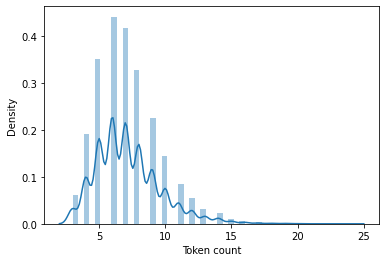

In [17]:
token_lens = []
for txt in df.text:
  toks = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(toks))

sns.distplot(token_lens)
print(np.max(token_lens))
plt.xlabel('Token count');
device = 'cuda:0' if cuda.is_available() else 'cpu'
print(device)

In [36]:
MAX_LEN = 20 # Len in function of dataset
training_set = CustomDataset(df[df.group == 'train'], tokenizer, MAX_LEN)

TEST_BATCH_SIZE = 8

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

# Dataloaders for pytorch

training_loader = DataLoader(training_set, **test_params)
model = bert_model
model.to(device)
optimizer = torch.optim.Adam(params =  model.parameters(), lr=1e-05)

for epoch in range(1):
    outputs = validation(epoch,training_loader)

# Models

# ConvNetwork

In [142]:
mod = CNN_Text(X_train.shape,len(df[df.group == 'train']['class'].unique()),0.2)
mod

CNN_Text(
  (convs): ModuleList(
    (0): Conv2d(1, 128, kernel_size=(3, 50), stride=(1, 1))
    (1): Conv2d(1, 128, kernel_size=(4, 50), stride=(1, 1))
    (2): Conv2d(1, 128, kernel_size=(5, 50), stride=(1, 1))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=384, out_features=150, bias=True)
  (soft): LogSoftmax(dim=1)
)

In [143]:
class CNN_Text(nn.Module):
    def __init__(self, inShape,outClasses,dp):
        super(CNN_Text, self).__init__()
        V = inShape[1]
        D = inShape[2]
        C = outClasses
        Ci = 1
        Co = 128
        Ks = [3,4,5]
        self.convs = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dp)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        out = self.soft(logit)
        return out

    
def train(train_iter, dev_iter, model, opt,epochs,Loss):
    model.cuda()
    optimizer = opt
    steps = 0
    best_acc = 0
    last_step = 0
    log_interval=1
    test_interval=100
    early_stop=100
    
    for epoch in range(1, epochs+1):
        for batch in train_iter:
            model.train()
            feature, target = batch.text, batch.label
            feature.t_(), target.sub_(1)  # batch first, index align
            feature, target = feature.cuda(), target.cuda()
            optimizer.zero_grad()
            logit = model(feature)
            loss = Loss(logit, target)
            loss.backward()
            optimizer.step()
            steps += 1
            if steps % log_interval == 0:
                corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
                accuracy = 100.0 * corrects/batch.batch_size
                sys.stdout.write(
                    '\rBatch[{}] - loss: {:.6f}  acc: {:.4f}%({}/{})'.format(steps, 
                                                                             loss.item(), 
                                                                             accuracy.item(),
                                                                             corrects.item(),
                                                                             batch.batch_size))
            if steps % test_interval == 0:
                dev_acc = eval(dev_iter, model, Loss)
                if dev_acc > best_acc:
                    best_acc = dev_acc
                    last_step = steps
                    #if args.save_best:
                    #    save(model, args.save_dir, 'best', steps)
                else:
                    if steps - last_step >= early_stop:
                        print('early stop by {} steps.'.format(early_stop))
            #elif steps % args.save_interval == 0:
            #    save(model, args.save_dir, 'snapshot', steps)


def eval(data_iter, model, Loss):
    model.eval()
    corrects, avg_loss = 0, 0
    for batch in data_iter:
        feature, target = batch.text, batch.label
        feature.t_(), target.sub_(1)  # batch first, index align
        feature, target = feature.cuda(), target.cuda()
        logit = model(feature)
        loss = Loss(logit, target, size_average=False)
        avg_loss += loss.item()
        corrects += (torch.max(logit, 1)
                     [1].view(target.size()).data == target.data).sum()

    size = len(data_iter.dataset)
    avg_loss /= size
    accuracy = 100.0 * corrects/size
    print('\nEvaluation - loss: {:.6f}  acc: {:.4f}%({}/{}) \n'.format(avg_loss, 
                                                                       accuracy, 
                                                                       corrects, 
                                                                       size))
    return accuracy

def save(model, save_dir, save_prefix, steps):
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    save_prefix = os.path.join(save_dir, save_prefix)
    save_path = '{}_steps_{}.pt'.format(save_prefix, steps)
    torch.save(model.state_dict(), save_path)
    
def customData(X,y):
    

In [ ]:
dropOut = 0.0
batch_size = 128
model = CNN_Text(X_train.shape,len(df[df.group == 'train']['class'].unique()),dropOut)
optimizer =  torch.optim.Adam(model.parameters(), lr=0.001)
Loss = nn.CrossEntropyLoss()
epochs = 200
train_iter = customData(X_train,y_train)
dev_iter = customData(X_val,y_val)
train(train_iter, dev_iter, model, optimizer,epochs,Loss)

# FF network

In [186]:
class FFnet(nn.Module):
    def __init__(self,inputs_shape,k_classes):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential( #sequential operation
            nn.Linear(inputs_shape[1], 2048), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(2048,1024), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.5),
            nn.Linear(512, 256), 
            nn.ReLU(), 
            nn.Linear(256, k_classes), 
            nn.LogSoftmax(dim=1))

    def forward(self, X):
        return self.net(X)

def fit_FFnet(x, y, model, opt, loss_fn, epochs = 10000):
    """Generic function for training a model """
    for epoch in range(epochs):
        loss = loss_fn(model(x), y) 

        loss.backward()
        opt.step()
        opt.zero_grad()
        
        if(epoch % 500 == 0):
            print('loss: ',loss)
            print('ep: ', epoch)
    
    return loss.item()

def accuracy(y_hat, y):
     pred = torch.argmax(y_hat, dim=1)
     return (pred == y).float().mean()

In [200]:
X_train = emb_USE(df[df.group == 'train'],emb_use_large) 
Y_train = torch.tensor(df[df.group == 'train']['class'].values)
k_classes = len(df['class'].unique())
X_train=X_train.to(device)
Y_train=Y_train.to(device)

model = FFnet(X_train.shape,k_classes)
print(model)
model.to(device) #moving the network to GPU

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.00005)

tic = time.time()
l = fit_v2(X_train, Y_train, model, opt, loss_fn)
print('Final loss', l)
toc = time.time()
print('Time taken', (toc - tic)/60.)

X_val = emb_USE(df[df.group == 'val'],emb_use_large) 
X_val = X_val.to(device)
y_val = torch.tensor(df[df.group == 'val']['class'].values)
y_pred = model(X_val).cpu()
print('Acc: ', accuracy(y_pred, y_val))

FFnet(
  (net): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=2048, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=512, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): ReLU()
    (11): Linear(in_features=256, out_features=150, bias=True)
    (12): LogSoftmax(dim=1)
  )
)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 1.16 GiB already allocated; 0 bytes free; 1.21 GiB reserved in total by PyTorch)

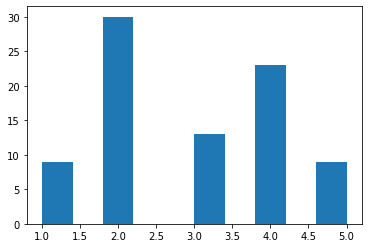

Most common class missclasiffied
class:  ['ENTY']  errors:  30
class:  ['LOC']  errors:  23
class:  ['HUM']  errors:  13
class:  ['NUM']  errors:  9
class:  ['DESC']  errors:  9
Most common pair of missclasiffied
class1:  ['LOC']  class2:  ['ENTY']  errors:  12
class1:  ['ENTY']  class2:  ['LOC']  errors:  11
class1:  ['ENTY']  class2:  ['NUM']  errors:  10
class1:  ['NUM']  class2:  ['ENTY']  errors:  7
class1:  ['HUM']  class2:  ['DESC']  errors:  7
class1:  ['ENTY']  class2:  ['DESC']  errors:  6
class1:  ['LOC']  class2:  ['HUM']  errors:  6
class1:  ['DESC']  class2:  ['HUM']  errors:  6
class1:  ['LOC']  class2:  ['NUM']  errors:  4
class1:  ['HUM']  class2:  ['LOC']  errors:  3
class1:  ['ENTY']  class2:  ['HUM']  errors:  3
class1:  ['NUM']  class2:  ['LOC']  errors:  2
class1:  ['HUM']  class2:  ['ENTY']  errors:  2
class1:  ['DESC']  class2:  ['LOC']  errors:  2
class1:  ['DESC']  class2:  ['ENTY']  errors:  1
class1:  ['HUM']  class2:  ['NUM']  errors:  1
class1:  ['LOC']  c

In [184]:
def err_info(y,y_pred,pars=True):
    targets = y
    outputs = y_pred.detach().numpy()
    sum = 0
    errs = list()
    pairs = list()
    for i in range(outputs.shape[0]):
        y_pred = np.where(outputs[i] == np.amax(outputs[i]))[0][0]
        y = targets[i]
        if (y == y_pred):
            sum += 1.
        else:
            errs.append(int(y.numpy()))
            pairs.append((int(y.numpy()),y_pred))
    plt.hist(errs)
    plt.show()

    encoder = LabelEncoder()
    encoder.classes_ = np.load(path_data+dataset+'-classesEncoder.npy',allow_pickle=True)

    print('Most common class missclasiffied')
    for c,v in Counter(errs).most_common():
        print('class: ',encoder.inverse_transform([c]),' errors: ',v)

    print('Most common pair of missclasiffied')
    if(pars):
        for t,v in Counter(pairs).most_common():
            c1,c2 = t
            print('class1: ',encoder.inverse_transform([c1]),' class2: ',encoder.inverse_transform([c2]) ,' errors: ',v)
    return errs

errs = err_info(y_val,y_pred)

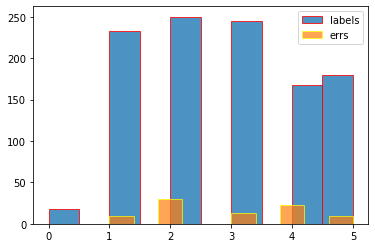

In [192]:
plt.hist(df[df.group == 'val']['class'].values,label='labels',alpha=.8, edgecolor='red')
plt.hist(errs,label='errs',alpha=0.7, edgecolor='yellow')
plt.legend()
plt.show()